In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split
from torchvision import transforms
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

class OverheadMNIST(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = read_idx(images_path)   
        self.labels = read_idx(labels_path)   
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = np.array(self.images[idx], copy=True)  
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label

data_dir = r"C:\CUADERNILLOS"  

transform = transforms.Compose([
    transforms.ToTensor(),                  
    transforms.Normalize((0.5,), (0.5,)),   
    transforms.Lambda(lambda x: x.view(-1)) 
])

train_full = OverheadMNIST(
    images_path=f"{data_dir}\\train-images-idx3-ubyte",
    labels_path=f"{data_dir}\\train-labels-idx1-ubyte",
    transform=transform
)

testset = OverheadMNIST(
    images_path=f"{data_dir}\\test-images-idx3-ubyte",
    labels_path=f"{data_dir}\\test-labels-idx1-ubyte",
    transform=transform
)

train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
trainset, valset = random_split(train_full, [train_size, val_size])

train_images = np.array([img.numpy() for img, label in trainset])
X_val = np.array([img.numpy() for img, label in valset])
X_test = np.array([img.numpy() for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_val = np.array([label for img, label in valset])
y_test = np.array([label for img, label in testset])

X_subset = train_images[:5000]
y_subset = train_labels[:5000]

classes = list(range(10))  # Dígitos 0-9
print("Clases:", classes)
print("Train:", len(trainset), "Val:", len(valset), "Test:", len(testset))

Clases: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Train: 6815 Val: 1704 Test: 1065


In [14]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float()
        self.Y = torch.from_numpy(Y).long()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),  # subconjunto de 5000
    'val': Dataset(X_val, y_val),          # validación
    'test': Dataset(X_test, y_test)        # test
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=1000, shuffle=False)
}

print("Tamaño train:", len(dataset['train']))
print("Tamaño val:", len(dataset['val']))
print("Tamaño test:", len(dataset['test']))

Tamaño train: 5000
Tamaño val: 1704
Tamaño test: 1065


In [17]:
from sklearn.metrics import accuracy_score
import numpy as np
import torch

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

def build_model(D_in=28*28, H=256, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(H, H//2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(H//2, D_out)
    )

def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))

        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))

        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1

        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
            
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} | val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    
    model.load_state_dict(torch.load('ckpt.pt'))
    return {
        'epoch': list(range(1, len(l)+1)),
        'loss': l, 'acc': acc,
        'val_loss': val_l, 'val_acc': val_acc
    }

In [24]:
results = {} 
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
results['SGD'] = fit(model, dataloader, optimizer, epochs=100)

Mejor modelo guardado con acc 0.10527 en epoch 1
Mejor modelo guardado con acc 0.14947 en epoch 5
Mejor modelo guardado con acc 0.18210 en epoch 7
Mejor modelo guardado con acc 0.18381 en epoch 9
Epoch 10/100 loss 2.29848 acc 0.10291 | val_loss 2.30249 val_acc 0.13855
Epoch 20/100 loss 2.29817 acc 0.10868 | val_loss 2.30316 val_acc 0.09630
Epoch 30/100 loss 2.29822 acc 0.10689 | val_loss 2.30326 val_acc 0.09630
Epoch 40/100 loss 2.29790 acc 0.10669 | val_loss 2.30328 val_acc 0.09630
Epoch 50/100 loss 2.29821 acc 0.10868 | val_loss 2.30314 val_acc 0.09630
Epoch 60/100 loss 2.29804 acc 0.10709 | val_loss 2.30315 val_acc 0.09630
Epoch 70/100 loss 2.29819 acc 0.10908 | val_loss 2.30291 val_acc 0.09630
Epoch 80/100 loss 2.29778 acc 0.10928 | val_loss 2.30294 val_acc 0.09630
Epoch 90/100 loss 2.29772 acc 0.11206 | val_loss 2.30286 val_acc 0.09630
Epoch 100/100 loss 2.29785 acc 0.11545 | val_loss 2.30260 val_acc 0.09630


In [25]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
results['Momentum'] = fit(model, dataloader, optimizer, epochs=100)

Mejor modelo guardado con acc 0.09448 en epoch 1
Mejor modelo guardado con acc 0.09630 en epoch 2
Mejor modelo guardado con acc 0.10345 en epoch 10
Epoch 10/100 loss 2.29897 acc 0.10669 | val_loss 2.30333 val_acc 0.10345
Mejor modelo guardado con acc 0.10651 en epoch 11
Mejor modelo guardado con acc 0.13968 en epoch 16
Mejor modelo guardado con acc 0.14449 en epoch 17
Mejor modelo guardado con acc 0.15068 en epoch 20
Epoch 20/100 loss 2.29325 acc 0.12719 | val_loss 2.29533 val_acc 0.15068
Mejor modelo guardado con acc 0.17555 en epoch 21
Mejor modelo guardado con acc 0.19854 en epoch 22
Mejor modelo guardado con acc 0.22387 en epoch 24
Mejor modelo guardado con acc 0.22909 en epoch 25
Epoch 30/100 loss 2.03556 acc 0.21915 | val_loss 2.02197 val_acc 0.18210
Mejor modelo guardado con acc 0.23964 en epoch 39
Epoch 40/100 loss 1.97960 acc 0.23089 | val_loss 1.95502 val_acc 0.23530
Mejor modelo guardado con acc 0.24669 en epoch 42
Mejor modelo guardado con acc 0.25926 en epoch 43
Mejor mode

In [26]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
results['RMSprop'] = fit(model, dataloader, optimizer, epochs=100)

Mejor modelo guardado con acc 0.32738 en epoch 1
Mejor modelo guardado con acc 0.39265 en epoch 2
Mejor modelo guardado con acc 0.42910 en epoch 3
Mejor modelo guardado con acc 0.46474 en epoch 4
Mejor modelo guardado con acc 0.47474 en epoch 5
Mejor modelo guardado con acc 0.49595 en epoch 6
Mejor modelo guardado con acc 0.50271 en epoch 7
Mejor modelo guardado con acc 0.51723 en epoch 8
Epoch 10/100 loss 1.36731 acc 0.51095 | val_loss 1.33547 val_acc 0.51031
Mejor modelo guardado con acc 0.53012 en epoch 11
Mejor modelo guardado con acc 0.53776 en epoch 14
Mejor modelo guardado con acc 0.54423 en epoch 15
Mejor modelo guardado con acc 0.55357 en epoch 16
Mejor modelo guardado con acc 0.56112 en epoch 19
Epoch 20/100 loss 1.16618 acc 0.58121 | val_loss 1.20177 val_acc 0.55441
Mejor modelo guardado con acc 0.56120 en epoch 21
Mejor modelo guardado con acc 0.56304 en epoch 22
Mejor modelo guardado con acc 0.57472 en epoch 23
Mejor modelo guardado con acc 0.57719 en epoch 26
Mejor modelo

In [27]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
results['Adam'] = fit(model, dataloader, optimizer, epochs=100)

Mejor modelo guardado con acc 0.25732 en epoch 1
Mejor modelo guardado con acc 0.34532 en epoch 2
Mejor modelo guardado con acc 0.41034 en epoch 3
Mejor modelo guardado con acc 0.43636 en epoch 4
Mejor modelo guardado con acc 0.46953 en epoch 5
Mejor modelo guardado con acc 0.49161 en epoch 6
Mejor modelo guardado con acc 0.50405 en epoch 7
Mejor modelo guardado con acc 0.51665 en epoch 8
Mejor modelo guardado con acc 0.52420 en epoch 10
Epoch 10/100 loss 1.35181 acc 0.51612 | val_loss 1.32174 val_acc 0.52420
Mejor modelo guardado con acc 0.52878 en epoch 11
Mejor modelo guardado con acc 0.53291 en epoch 12
Mejor modelo guardado con acc 0.53318 en epoch 14
Mejor modelo guardado con acc 0.54352 en epoch 15
Mejor modelo guardado con acc 0.54865 en epoch 16
Mejor modelo guardado con acc 0.55520 en epoch 18
Mejor modelo guardado con acc 0.55980 en epoch 19
Epoch 20/100 loss 1.15782 acc 0.58499 | val_loss 1.18161 val_acc 0.55904
Mejor modelo guardado con acc 0.56225 en epoch 21
Mejor modelo

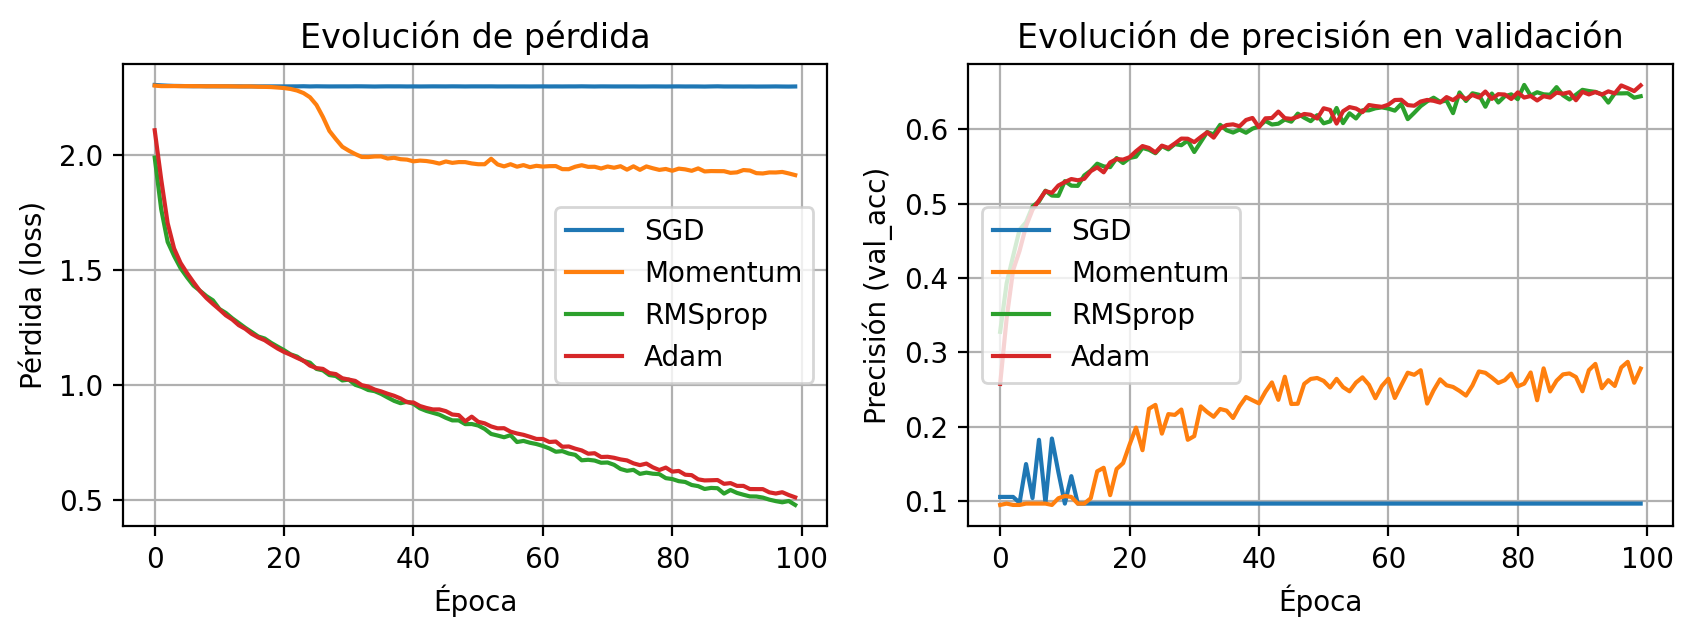

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
for name, hist in results.items():
    ax.plot(hist['loss'], label=name)
ax.legend()
ax.grid(True)
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida (loss)')
ax.set_title("Evolución de pérdida")

ax = plt.subplot(122)
for name, hist in results.items():
    ax.plot(hist['val_acc'], label=name)
ax.legend()
ax.grid(True)
ax.set_ylabel('Precisión (val_acc)')
ax.set_xlabel('Época')
ax.set_title("Evolución de precisión en validación")

plt.show()

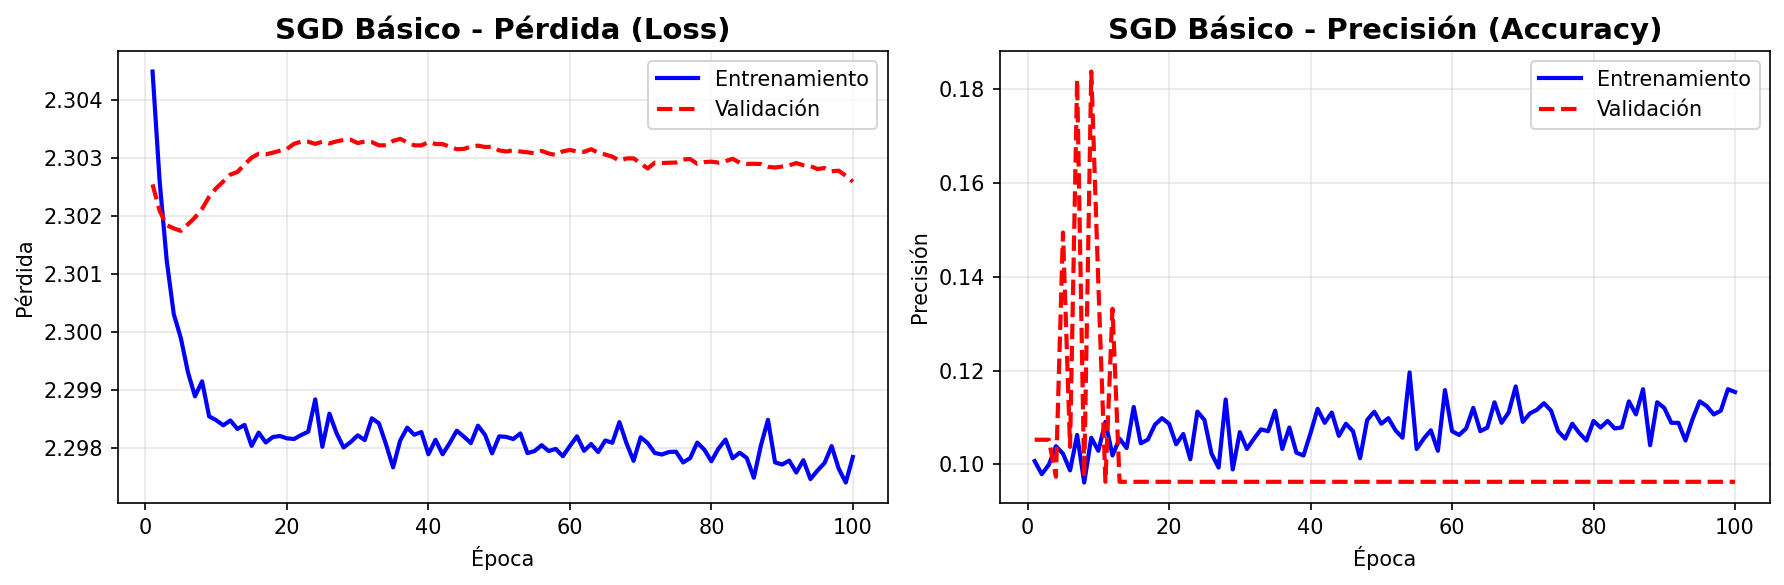

SGD Básico - Precisión final: 9.63%
SGD Básico - Mejor precisión alcanzada: 18.38%
SGD Básico - Épocas entrenadas: 100


In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(results['SGD']['epoch'], results['SGD']['loss'], 'b-', linewidth=2, label='Entrenamiento')
ax1.plot(results['SGD']['epoch'], results['SGD']['val_loss'], 'r--', linewidth=2, label='Validación')
ax1.set_title('SGD Básico - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(results['SGD']['epoch'], results['SGD']['acc'], 'b-', linewidth=2, label='Entrenamiento')
ax2.plot(results['SGD']['epoch'], results['SGD']['val_acc'], 'r--', linewidth=2, label='Validación')
ax2.set_title('SGD Básico - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = results['SGD']['val_acc'][-1]
best_acc = max(results['SGD']['val_acc'])
print(f"SGD Básico - Precisión final: {final_acc:.2%}")
print(f"SGD Básico - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"SGD Básico - Épocas entrenadas: {len(results['SGD']['epoch'])}")


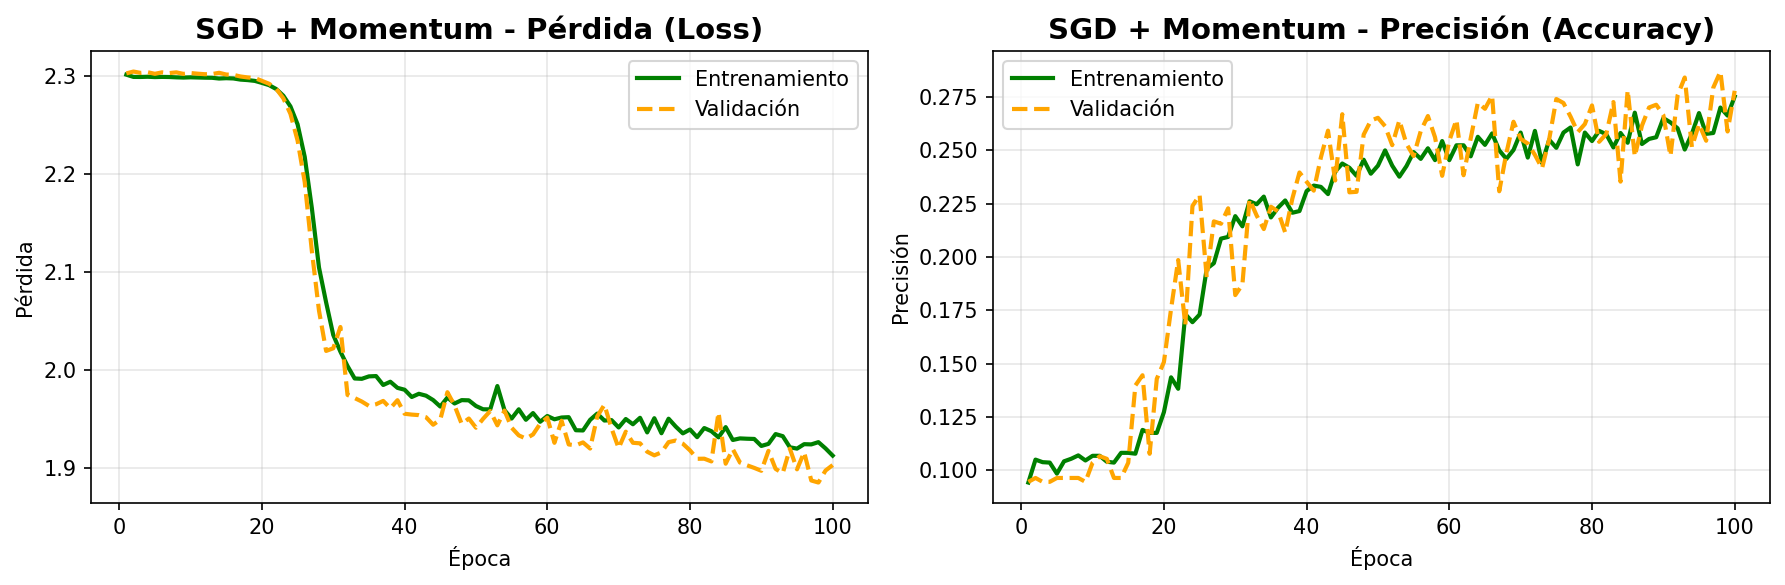

SGD + Momentum - Precisión final: 27.79%
SGD + Momentum - Mejor precisión alcanzada: 28.70%
SGD + Momentum - Épocas entrenadas: 100


In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(results['Momentum']['epoch'], results['Momentum']['loss'], 'g-', linewidth=2, label='Entrenamiento')
ax1.plot(results['Momentum']['epoch'], results['Momentum']['val_loss'], 'orange', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('SGD + Momentum - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(results['Momentum']['epoch'], results['Momentum']['acc'], 'g-', linewidth=2, label='Entrenamiento')
ax2.plot(results['Momentum']['epoch'], results['Momentum']['val_acc'], 'orange', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('SGD + Momentum - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = results['Momentum']['val_acc'][-1]
best_acc = max(results['Momentum']['val_acc'])
print(f"SGD + Momentum - Precisión final: {final_acc:.2%}")
print(f"SGD + Momentum - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"SGD + Momentum - Épocas entrenadas: {len(results['Momentum']['epoch'])}")


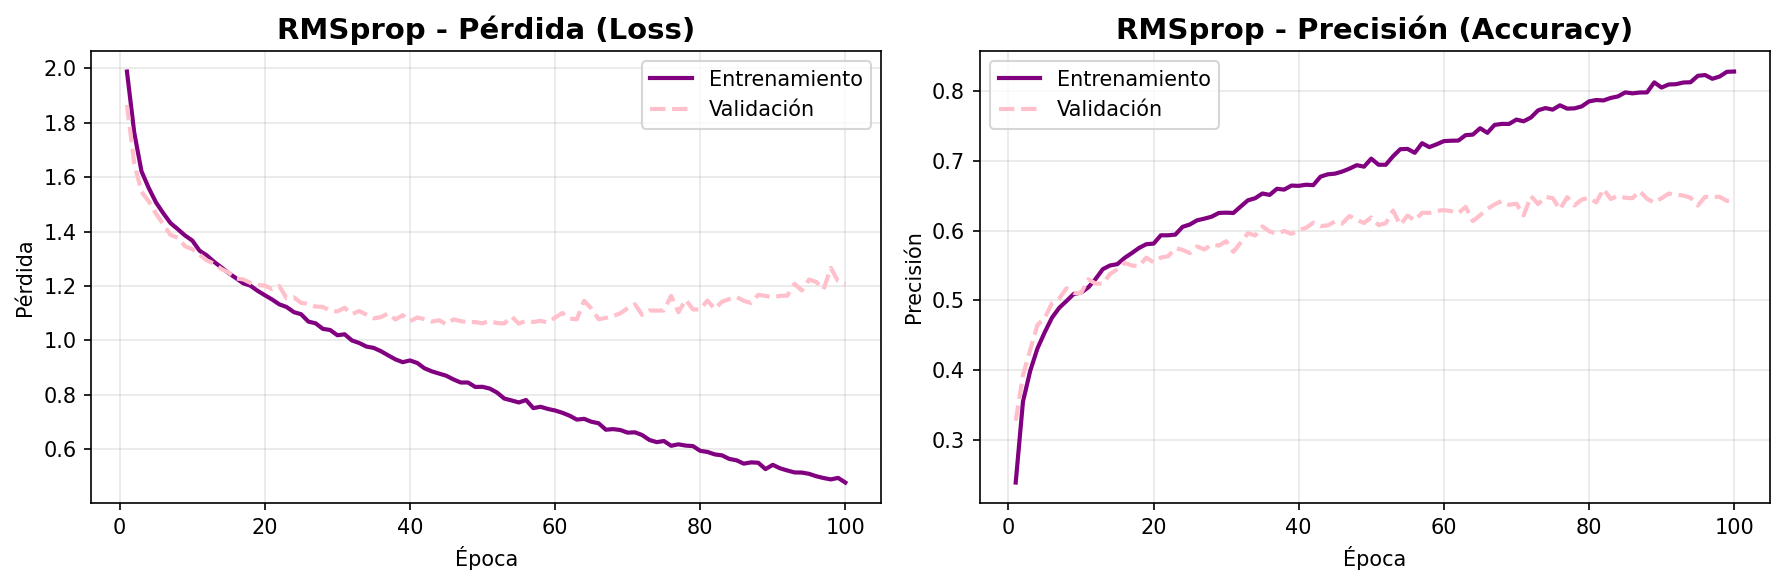

RMSprop - Precisión final: 64.43%
RMSprop - Mejor precisión alcanzada: 65.95%
RMSprop - Épocas entrenadas: 100


In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(results['RMSprop']['epoch'], results['RMSprop']['loss'], 'purple', linewidth=2, label='Entrenamiento')
ax1.plot(results['RMSprop']['epoch'], results['RMSprop']['val_loss'], 'pink', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('RMSprop - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(results['RMSprop']['epoch'], results['RMSprop']['acc'], 'purple', linewidth=2, label='Entrenamiento')
ax2.plot(results['RMSprop']['epoch'], results['RMSprop']['val_acc'], 'pink', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('RMSprop - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = results['RMSprop']['val_acc'][-1]
best_acc = max(results['RMSprop']['val_acc'])
print(f"RMSprop - Precisión final: {final_acc:.2%}")
print(f"RMSprop - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"RMSprop - Épocas entrenadas: {len(results['RMSprop']['epoch'])}")


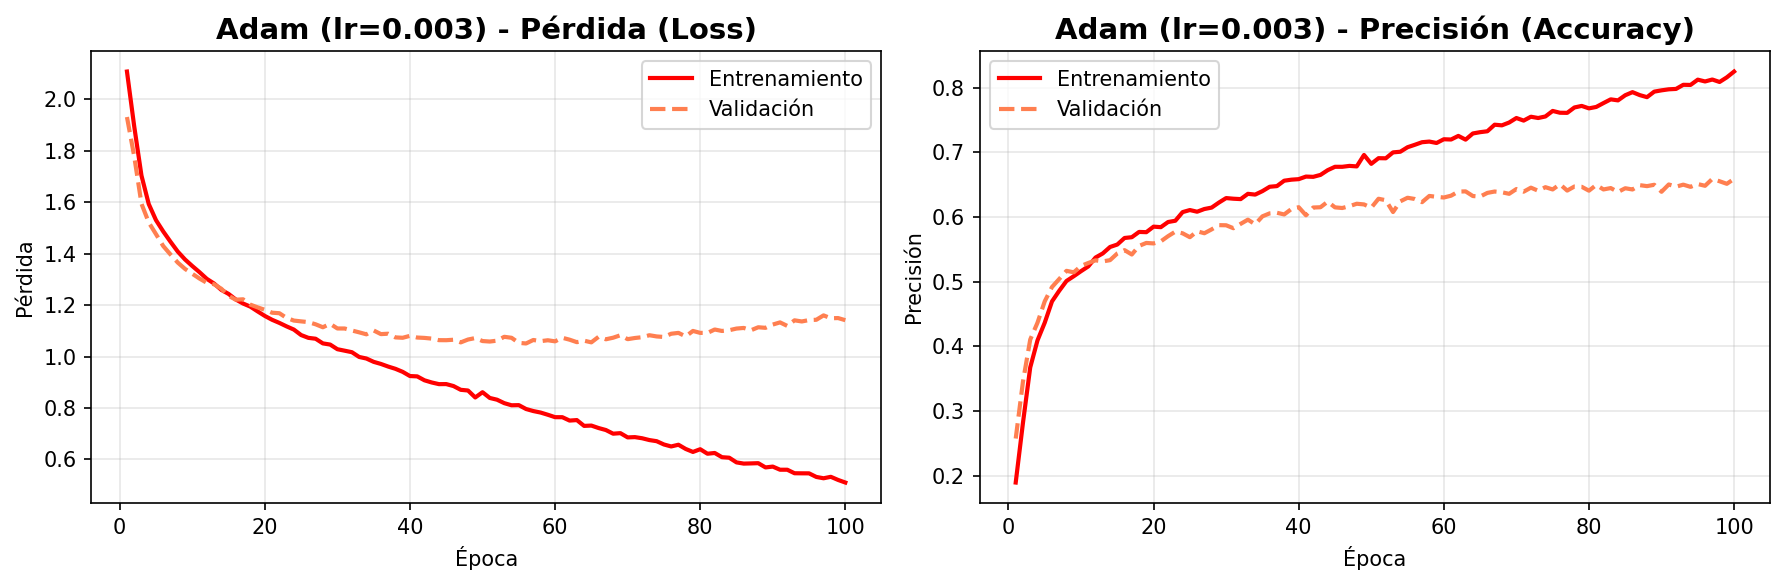

Adam (mejorado) - Precisión final: 65.89%
Adam (mejorado) - Mejor precisión alcanzada: 65.89%
Adam (mejorado) - Épocas entrenadas: 100


In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(results['Adam']['epoch'], results['Adam']['loss'], 'red', linewidth=2, label='Entrenamiento')
ax1.plot(results['Adam']['epoch'], results['Adam']['val_loss'], 'coral', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('Adam (lr=0.003) - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(results['Adam']['epoch'], results['Adam']['acc'], 'red', linewidth=2, label='Entrenamiento')
ax2.plot(results['Adam']['epoch'], results['Adam']['val_acc'], 'coral', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('Adam (lr=0.003) - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = results['Adam']['val_acc'][-1]
best_acc = max(results['Adam']['val_acc'])
print(f"Adam (mejorado) - Precisión final: {final_acc:.2%}")
print(f"Adam (mejorado) - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"Adam (mejorado) - Épocas entrenadas: {len(results['Adam']['epoch'])}")


In [33]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    
    for e in range(1, epochs+1):
        _l, _acc = [], []
        
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
            
        model.train()
        
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        
        if scheduler:
            scheduler.step()
        
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
            
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [34]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

hist_step = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.09630 en epoch 1
Mejor modelo guardado con acc 0.10651 en epoch 8
Epoch 10/30 loss 2.29884 acc 0.09693 val_loss 2.30274 val_acc 0.10345 lr 0.01000
Mejor modelo guardado con acc 0.12698 en epoch 11
Mejor modelo guardado con acc 0.13605 en epoch 12
Mejor modelo guardado con acc 0.17197 en epoch 13
Epoch 20/30 loss 2.29744 acc 0.11047 val_loss 2.30277 val_acc 0.09630 lr 0.00100
Epoch 30/30 loss 2.29745 acc 0.11624 val_loss 2.30274 val_acc 0.09630 lr 0.00010


In [35]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.10527 en epoch 1
Mejor modelo guardado con acc 0.10651 en epoch 10
Epoch 10/30 loss 2.29906 acc 0.10151 val_loss 2.30323 val_acc 0.10651 lr 0.00842
Mejor modelo guardado con acc 0.14239 en epoch 13
Epoch 20/30 loss 2.29827 acc 0.10589 val_loss 2.30314 val_acc 0.09630 lr 0.00446
Epoch 30/30 loss 2.29774 acc 0.10788 val_loss 2.30269 val_acc 0.09630 lr 0.00050


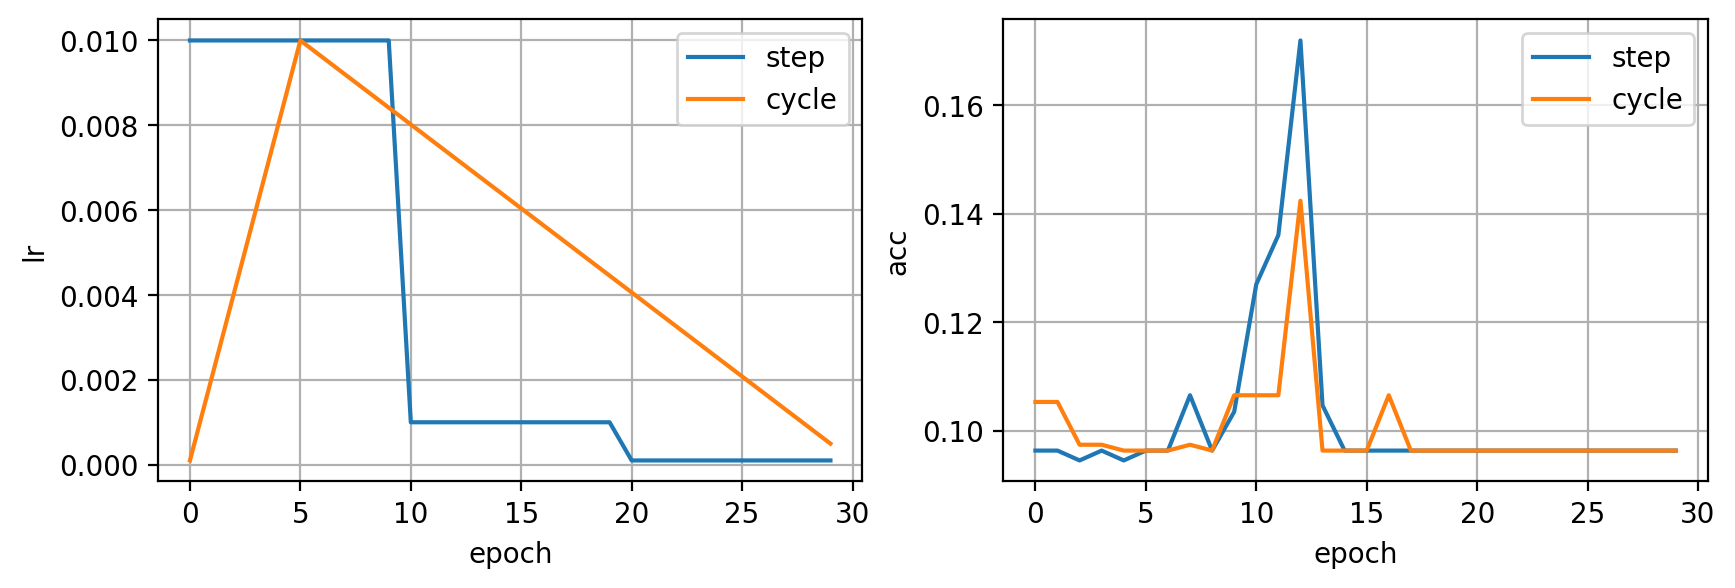


RESULTADOS DE SCHEDULERS:

StepLR - Precisión final: 9.63%
StepLR - Mejor precisión alcanzada: 17.20%
StepLR - Épocas entrenadas: 30

CyclicLR - Precisión final: 9.63%
CyclicLR - Mejor precisión alcanzada: 14.24%
CyclicLR - Épocas entrenadas: 30

Mejor resultado: StepLR


In [36]:
fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
ax.plot(hist_step['lr'], label="step")
ax.plot(hist_cycle['lr'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('lr')

ax = plt.subplot(122)
ax.plot(hist_step['val_acc'], label="step")
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

print("\nRESULTADOS DE SCHEDULERS:")
print()

final_acc_step = hist_step['val_acc'][-1]
best_acc_step = max(hist_step['val_acc'])
epochs_step = len(hist_step['epoch'])
print(f"StepLR - Precisión final: {final_acc_step:.2%}")
print(f"StepLR - Mejor precisión alcanzada: {best_acc_step:.2%}")
print(f"StepLR - Épocas entrenadas: {epochs_step}")

print()

final_acc_cycle = hist_cycle['val_acc'][-1]
best_acc_cycle = max(hist_cycle['val_acc'])
epochs_cycle = len(hist_cycle['epoch'])
print(f"CyclicLR - Precisión final: {final_acc_cycle:.2%}")
print(f"CyclicLR - Mejor precisión alcanzada: {best_acc_cycle:.2%}")
print(f"CyclicLR - Épocas entrenadas: {epochs_cycle}")

print(f"\nMejor resultado: {'StepLR' if best_acc_step > best_acc_cycle else 'CyclicLR'}")

In [40]:
import numpy as np

mean = (train_images / 255).mean()

std = (train_images / 255).std()

mean, std

(np.float32(-0.00024157693), np.float32(0.0020962919))

In [42]:
train_images_norm = ((train_images / 255) - mean) / std

train_images_norm.mean(), train_images_norm.std()

(np.float32(2.957537e-08), np.float32(1.0000001))

In [46]:
X_test_norm = np.array([ 
    (np.array(img)/255. - mean) / std 
    for img, label in testset 
])

X_train_norm = ((train_images / 255.) - mean) / std
X_val_norm   = ((X_val / 255.) - mean) / std
X_subset_norm = X_train_norm[:5000]

print("Formas de los conjuntos normalizados:")
print("X_train_norm:", X_train_norm.shape)
print("X_val_norm:",   X_val_norm.shape)
print("X_test_norm:",  X_test_norm.shape)
print("X_subset_norm:", X_subset_norm.shape)

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_16752\490208119.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  (np.array(img)/255. - mean) / std


Formas de los conjuntos normalizados:
X_train_norm: (6815, 784)
X_val_norm: (1704, 784)
X_test_norm: (1065, 784)
X_subset_norm: (5000, 784)


In [47]:
dataset_norm = {
    'train': Dataset(X_subset_norm, y_subset),
    'val': Dataset(X_val_norm, y_val),
}

dataloader_norm = {
    'train': torch.utils.data.DataLoader(dataset_norm['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset_norm['val'], batch_size=1000, shuffle=False)
}

print(f"Tamaño del dataset de entrenamiento normalizado: {len(dataset_norm['train'])}")
print(f"Tamaño del dataset de validación normalizado: {len(dataset_norm['val'])}")
print(f"Verificación - ambos datasets deben tener contenido para evitar errores")
len(dataset_norm['train']), len(dataset_norm['val'])

Tamaño del dataset de entrenamiento normalizado: 5000
Tamaño del dataset de validación normalizado: 1704
Verificación - ambos datasets deben tener contenido para evitar errores


(5000, 1704)

In [48]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_norm = fit(model, dataloader_norm, optimizer)

Mejor modelo guardado con acc 0.08959 en epoch 1
Mejor modelo guardado con acc 0.10801 en epoch 5
Mejor modelo guardado con acc 0.11198 en epoch 8
Epoch 10/100 loss 2.29853 acc 0.10908 val_loss 2.30275 val_acc 0.09630 lr 0.00100
Epoch 20/100 loss 2.29819 acc 0.10549 val_loss 2.30303 val_acc 0.09630 lr 0.00100
Epoch 30/100 loss 2.29757 acc 0.10828 val_loss 2.30296 val_acc 0.09630 lr 0.00100
Epoch 40/100 loss 2.29753 acc 0.11425 val_loss 2.30260 val_acc 0.09630 lr 0.00100
Mejor modelo guardado con acc 0.13316 en epoch 43
Epoch 50/100 loss 2.29690 acc 0.12261 val_loss 2.30222 val_acc 0.09630 lr 0.00100
Epoch 60/100 loss 2.29658 acc 0.13057 val_loss 2.30167 val_acc 0.09630 lr 0.00100
Epoch 70/100 loss 2.29542 acc 0.12878 val_loss 2.30096 val_acc 0.10890 lr 0.00100
Mejor modelo guardado con acc 0.13502 en epoch 71
Mejor modelo guardado con acc 0.14107 en epoch 74
Mejor modelo guardado con acc 0.15973 en epoch 75
Epoch 80/100 loss 2.29487 acc 0.13455 val_loss 2.29952 val_acc 0.13402 lr 0.001

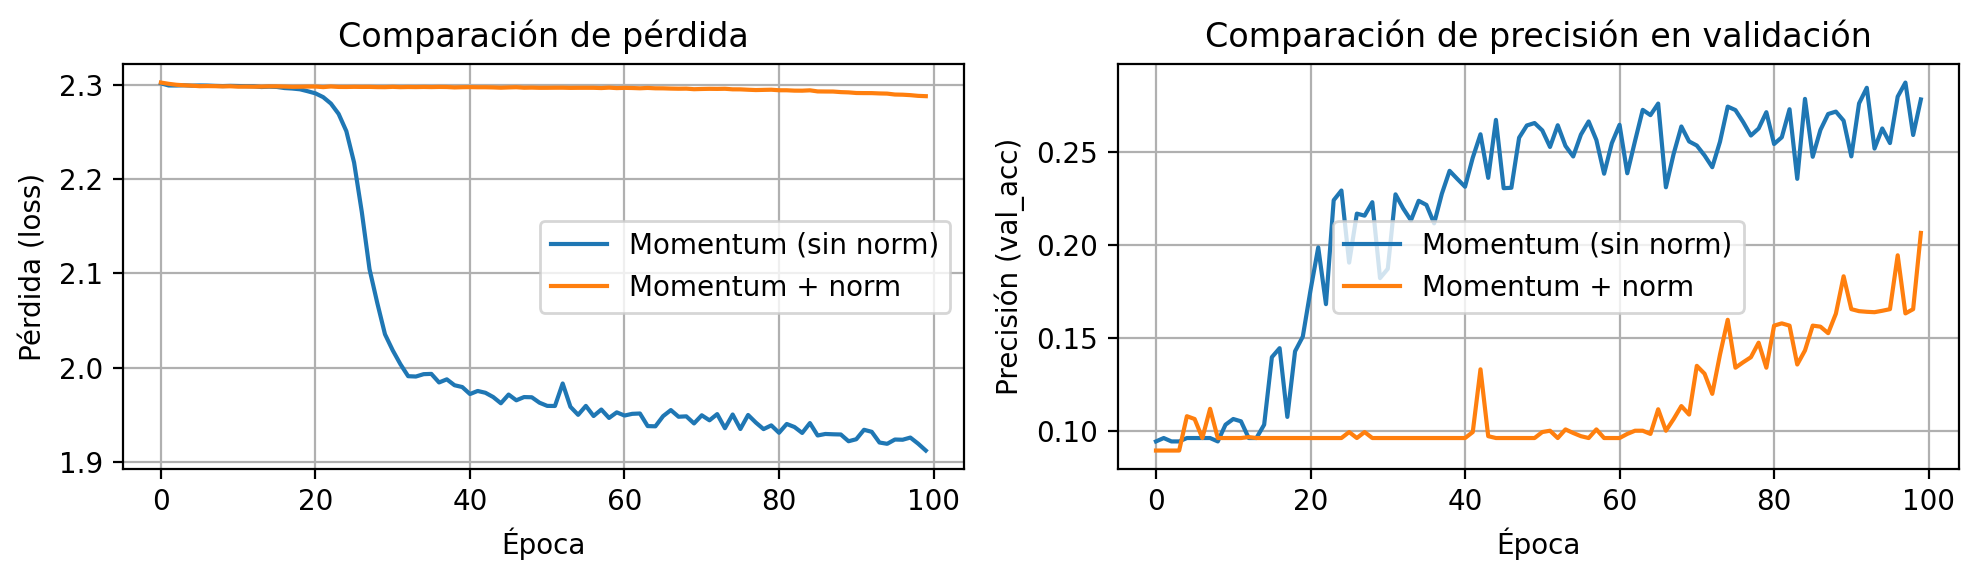

In [49]:
fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
ax.plot(results['Momentum']['loss'], label="Momentum (sin norm)")
ax.plot(hist_norm['loss'], label="Momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida (loss)')
ax.set_title("Comparación de pérdida")

ax = plt.subplot(122)
ax.plot(results['Momentum']['val_acc'], label="Momentum (sin norm)")
ax.plot(hist_norm['val_acc'], label="Momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('Época')
ax.set_ylabel('Precisión (val_acc)')
ax.set_title("Comparación de precisión en validación")

plt.tight_layout()
plt.show()

In [50]:
def build_model(D_in=784, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

In [51]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.54884 en epoch 1
Mejor modelo guardado con acc 0.59266 en epoch 2
Mejor modelo guardado con acc 0.60201 en epoch 3
Mejor modelo guardado con acc 0.61900 en epoch 4
Mejor modelo guardado con acc 0.64126 en epoch 5
Mejor modelo guardado con acc 0.65644 en epoch 7
Mejor modelo guardado con acc 0.65663 en epoch 8
Epoch 10/100 loss 0.69370 acc 0.78523 val_loss 0.98257 val_acc 0.63874 lr 0.00100
Mejor modelo guardado con acc 0.66673 en epoch 11
Mejor modelo guardado con acc 0.66957 en epoch 15
Epoch 20/100 loss 0.40026 acc 0.87818 val_loss 1.06657 val_acc 0.65037 lr 0.00100
Mejor modelo guardado con acc 0.66965 en epoch 21
Epoch 30/100 loss 0.24564 acc 0.92834 val_loss 1.12038 val_acc 0.64942 lr 0.00100
Epoch 40/100 loss 0.18389 acc 0.94606 val_loss 1.18109 val_acc 0.65765 lr 0.00100
Epoch 50/100 loss 0.14142 acc 0.96278 val_loss 1.32059 val_acc 0.64952 lr 0.00100
Epoch 60/100 loss 0.11714 acc 0.96557 val_loss 1.38548 val_acc 0.64910 lr 0.00100
Epoch 70/100 lo

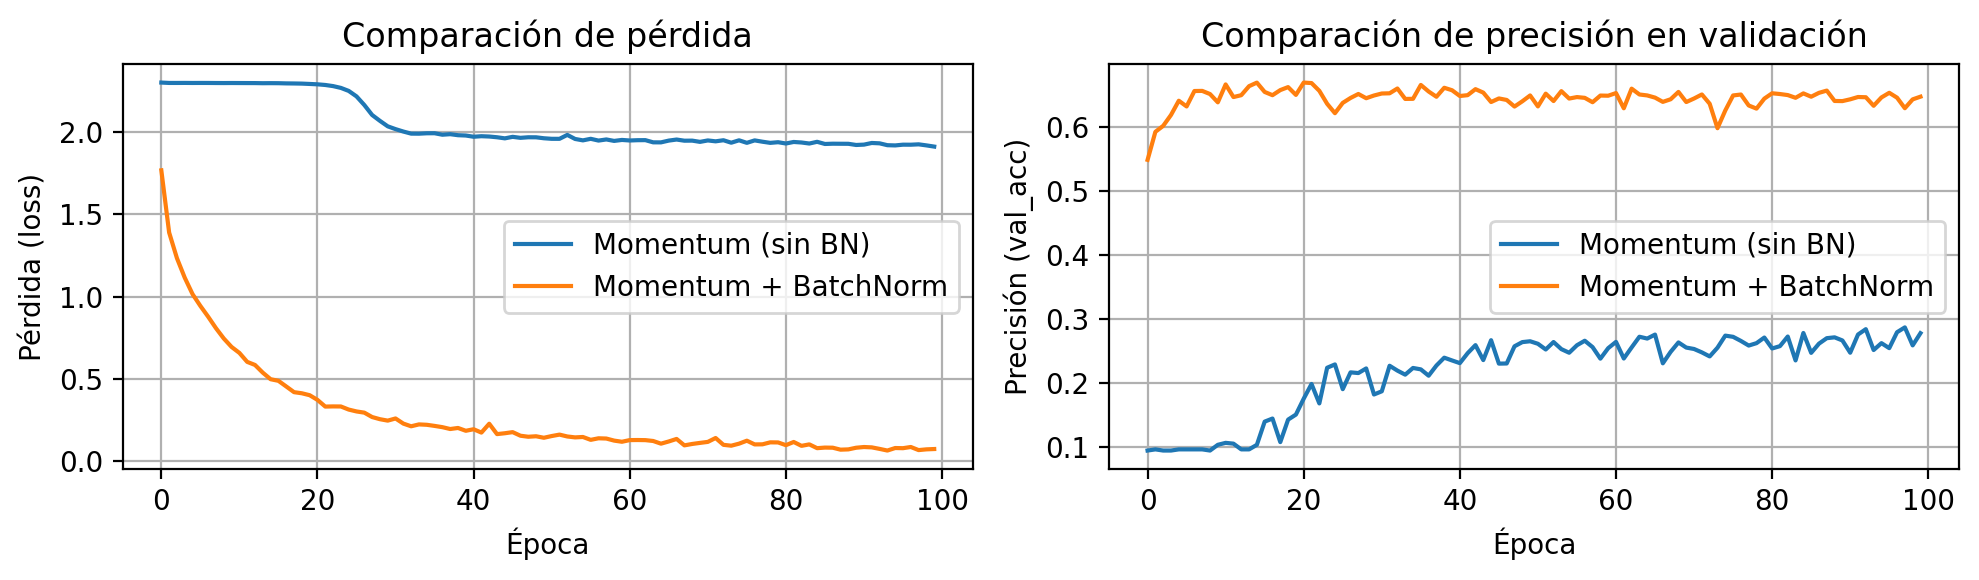

In [52]:
fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
ax.plot(results['Momentum']['loss'], label="Momentum (sin BN)")
ax.plot(hist_bn['loss'], label="Momentum + BatchNorm")
ax.legend()
ax.grid(True)
ax.set_xlabel('Época')
ax.set_ylabel('Pérdida (loss)')
ax.set_title("Comparación de pérdida")

ax = plt.subplot(122)
ax.plot(results['Momentum']['val_acc'], label="Momentum (sin BN)")
ax.plot(hist_bn['val_acc'], label="Momentum + BatchNorm")
ax.legend()
ax.grid(True)
ax.set_xlabel('Época')
ax.set_ylabel('Precisión (val_acc)')
ax.set_title("Comparación de precisión en validación")

plt.tight_layout()
plt.show()


In [53]:
def build_optimal_model(D_in=784, H=256, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),

        torch.nn.Linear(H, H//2),
        torch.nn.BatchNorm1d(H//2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.05),

        torch.nn.Linear(H//2, D_out)
    )

model_optimal = build_optimal_model()

optimizer_optimal = torch.optim.Adam(model_optimal.parameters(), lr=0.0001)
scheduler_optimal = torch.optim.lr_scheduler.StepLR(optimizer_optimal, step_size=50, gamma=0.9)

dataloader_optimal = {
    'train': torch.utils.data.DataLoader(dataset_norm['train'], batch_size=64, shuffle=True),
    'val':   torch.utils.data.DataLoader(dataset_norm['val'], batch_size=1000, shuffle=False)
}

def fit_optimal(model, dataloader, optimizer, scheduler=None, epochs=80, log_each=10, early_stopping=20):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr_hist = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    
    for e in range(1, epochs+1):
        _l, _acc = [], []
        
        for param_group in optimizer.param_groups:
            lr_hist.append(param_group['lr'])
        
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        
        model.eval()
        _l_val, _acc_val = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l_val.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc_val.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        
        val_l.append(np.mean(_l_val))
        val_acc.append(np.mean(_acc_val))
        
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt_optimal.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        
        if scheduler and e % 10 == 0:
            scheduler.step()
        
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
            
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} "
                  f"val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr_hist[-1]:.6f}")
    
    try:
        model.load_state_dict(torch.load('ckpt_optimal.pt'))
        print(" Mejor modelo cargado exitosamente")
    except FileNotFoundError:
        print(" No se guardó ningún modelo mejorado")
    
    return {
        'epoch': list(range(1, len(l)+1)), 
        'loss': l, 
        'acc': acc, 
        'val_loss': val_l, 
        'val_acc': val_acc, 
        'lr': lr_hist
    }

hist_optimal = fit_optimal(model_optimal, dataloader_optimal, optimizer_optimal, scheduler_optimal)

Mejor modelo guardado con acc 0.25137 en epoch 1
Mejor modelo guardado con acc 0.59280 en epoch 2
Mejor modelo guardado con acc 0.62377 en epoch 3
Mejor modelo guardado con acc 0.63408 en epoch 4
Mejor modelo guardado con acc 0.63879 en epoch 5
Mejor modelo guardado con acc 0.65331 en epoch 6
Mejor modelo guardado con acc 0.66734 en epoch 7
Mejor modelo guardado con acc 0.68131 en epoch 8
Epoch 10/80 loss 0.82359 acc 0.77255 val_loss 0.99279 val_acc 0.67910 lr 0.000100
Mejor modelo guardado con acc 0.68481 en epoch 12
Mejor modelo guardado con acc 0.69596 en epoch 13
Mejor modelo guardado con acc 0.69917 en epoch 15
Mejor modelo guardado con acc 0.70559 en epoch 16
Mejor modelo guardado con acc 0.71448 en epoch 19
Epoch 20/80 loss 0.47736 acc 0.88370 val_loss 0.88339 val_acc 0.70196 lr 0.000100
Epoch 30/80 loss 0.29549 acc 0.92919 val_loss 0.90867 val_acc 0.69241 lr 0.000100
Entrenamiento detenido en epoch 39 por no mejorar en 20 epochs seguidas
 Mejor modelo cargado exitosamente


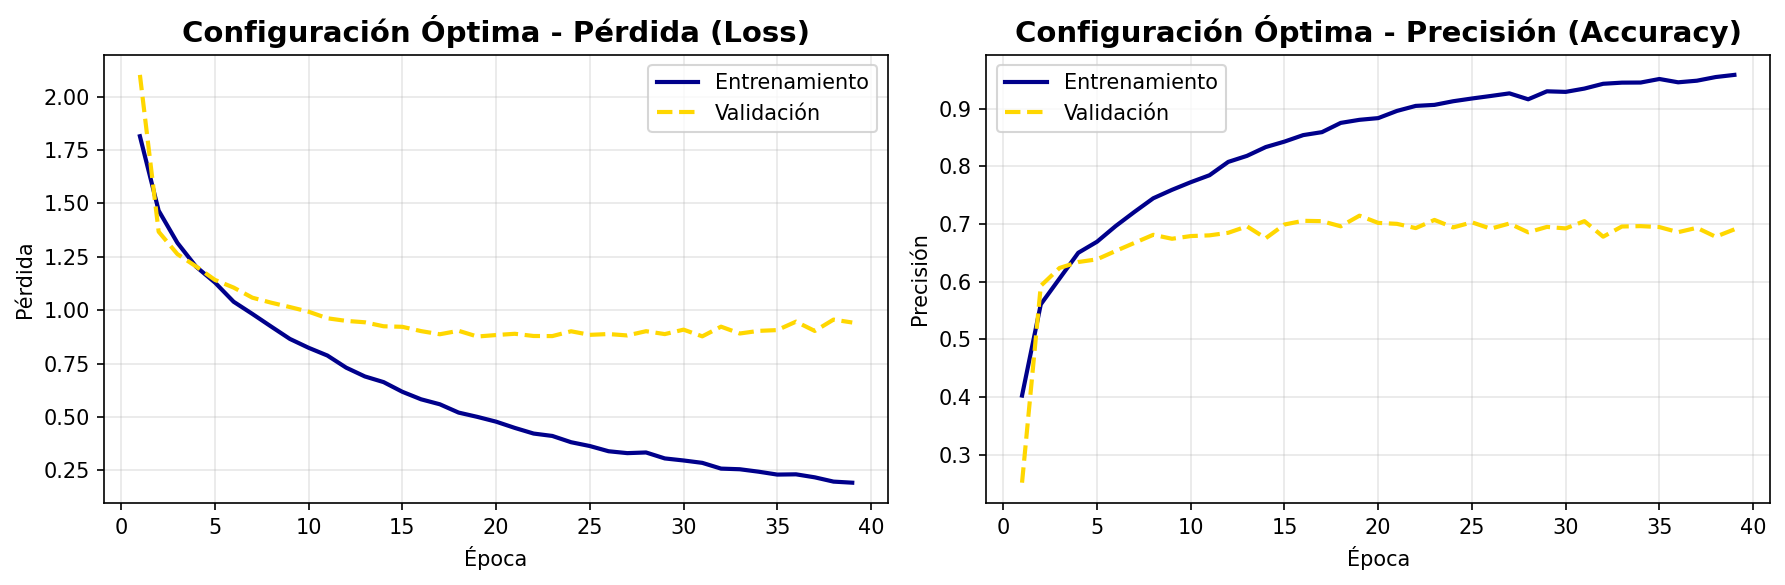

Configuración Óptima - Precisión final: 69.08%
Configuración Óptima - Mejor precisión alcanzada: 71.45%
Configuración Óptima - Épocas entrenadas: 39


In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

# Pérdida
ax1.plot(hist_optimal['epoch'], hist_optimal['loss'], 'darkblue', linewidth=2, label='Entrenamiento')
ax1.plot(hist_optimal['epoch'], hist_optimal['val_loss'], 'gold', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('Configuración Óptima - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Precisión
ax2.plot(hist_optimal['epoch'], hist_optimal['acc'], 'darkblue', linewidth=2, label='Entrenamiento')
ax2.plot(hist_optimal['epoch'], hist_optimal['val_acc'], 'gold', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('Configuración Óptima - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === Métricas finales ===
final_acc = hist_optimal['val_acc'][-1]
best_acc = max(hist_optimal['val_acc'])
print(f"Configuración Óptima - Precisión final: {final_acc:.2%}")
print(f"Configuración Óptima - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"Configuración Óptima - Épocas entrenadas: {len(hist_optimal['epoch'])}")